In [1]:
# モジュールをインポート
import random
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 遺伝子をランダムに生成
def generate_gene():
    individual = []
    for i in range(100):
        # 0または1をランダムに生成して個体に追加
        individual.append(random.randint(0,1))
    return individual

# 初期個体群を生成
def init_population(size):
    population = []
    for i in range(size):
        # generate_gene関数を呼び出して個体を生成し、個体群に追加
        population.append(generate_gene())
    return population

# 評価関数
def evaluate(individual):
    return sum(individual) # 個体の遺伝子の合計を評価値として返す

# 交叉
def crossover(ind1,ind2):
    ind_1, ind_2 = deepcopy(ind1), deepcopy(ind2) # 個体のディープコピーを作成
    # 交差点を決める
    size = min(len(ind_1), len(ind_2))
    cxpoint1 = random.randint(1, size)
    cxpoint2 = random.randint(1, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else:
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1
    # 交叉を実行
    ind_1[cxpoint1:cxpoint2], ind_2[cxpoint1:cxpoint2] \
        = ind_2[cxpoint1:cxpoint2], ind_1[cxpoint1:cxpoint2]
        
    return ind_1, ind_2

# 突然変異
def mutate(ind,indpb):
    individual = deepcopy(ind) # 個体のディープコピーを作成
    for i in range(len(individual)):
        if random.random() < indpb:
            individual[i] = type(individual[i])(not individual[i])
    
    return individual

# 選択
def select(ind_fit,num,tournsize=3):
    chosen = pd.DataFrame()
    for i in range(num):
        # トーナメント選択を実行
        aspirants = ind_fit.sample(n=tournsize)
        # 最大適応度の個体を選択
        Max = aspirants[aspirants["fitness"] == aspirants["fitness"].max()]        
        if len(Max) == 1:
            chosen = pd.concat([chosen,Max])
        else:
            chosen = pd.concat([chosen,Max.sample(n=1)])
    return chosen.reset_index(drop=True)

# 最良個体を探す
def find_best(ind_fit):
    best_num = ind_fit["fitness"].idxmax()
    best_ind = ind_fit["individual"][best_num]
    best_fit = ind_fit["fitness"][best_num]
    return best_ind,best_fit

In [3]:
def main():
    POPSZ, CXPB, MUTPB = 100, 0.5, 0.2
    print("Start of evolution")
    
    # 初期個体群を生成
    pop = init_population(POPSZ)
    # 初期個体群の評価
    fits = list(map(evaluate,pop))
    # 評価値と個体のデータフレームを作成
    ind_fit = pd.concat([pd.Series(pop,name="individual"),pd.Series(fits,name="fitness")], axis=1)
    stats = ind_fit["fitness"].agg(['min', 'max', 'mean', 'std'])
    g = 0
    log = []
    print("Gen    Min    Max   Mean    Std")

    while stats["max"] < 100 and g < 150:
        g = g + 1
        
        # 選択関数によって、残る子孫を決める。
        offspring = select(ind_fit,len(ind_fit))
        # 子孫の個体情報をリストにする
        offspring_inds = offspring["individual"].tolist()

        # 交叉
        for i,(child1, child2) in enumerate(zip(offspring_inds[::2], offspring_inds[1::2])):
            if random.random() < CXPB:
                child_1,child_2 = crossover(child1,child2)
                offspring_inds[i*2] = child_1
                offspring_inds[i*2+1] = child_2
        # 突然変異      
        for i,mutant in enumerate(offspring_inds):
            if random.random() < MUTPB:
                offspring_inds[i] = mutate(mutant,indpb = 0.05)

        # 交叉と突然変異後の子孫の評価
        offspring_fits = list(map(evaluate,offspring_inds))
        # 評価値と個体群のデータフレームを更新
        ind_fit = pd.concat([pd.Series(offspring_inds,name="individual"),pd.Series(offspring_fits,name="fitness")], axis=1)
        
        # 個体の適応度の統計量（最小値、最大値、平均、標準偏差）を計算
        stats = ind_fit["fitness"].agg(['min', 'max', 'mean', 'std'])
        log.append(stats)
        # 統計量を小数点以下1桁までフォーマットして辞書に格納
        formatted_stats = {key: f"{value:.1f}" for key, value in stats.items()}
        # 世代数と統計量を出力
        print(f"{g:>3} {formatted_stats['min']:>6} {formatted_stats['max']:>6} {formatted_stats['mean']:>6} {formatted_stats['std']:>6}")  

    print("-- End of (successful) evolution --")

    best_ind,best_fit = find_best(ind_fit)
    print(f"Best individual is {best_ind}, Fitness: {best_fit}")
    return log, best_ind

In [4]:
if __name__ == "__main__":
    log, best_ind = main()

Start of evolution
Gen    Min    Max   Mean    Std
  1   47.0   64.0   54.0    3.7
  2   46.0   64.0   57.4    3.4
  3   51.0   66.0   60.2    2.9
  4   55.0   68.0   62.3    2.5
  5   55.0   70.0   64.1    2.6
  6   56.0   73.0   65.6    3.0
  7   62.0   76.0   68.0    2.4
  8   64.0   74.0   69.7    2.2
  9   66.0   75.0   70.9    2.0
 10   64.0   75.0   71.8    2.1
 11   66.0   77.0   73.2    2.0
 12   66.0   80.0   74.1    2.1
 13   65.0   80.0   75.0    2.1
 14   70.0   80.0   76.1    1.9
 15   73.0   84.0   77.6    1.7
 16   72.0   84.0   78.3    1.9
 17   72.0   84.0   79.0    2.2
 18   73.0   84.0   79.6    2.0
 19   74.0   84.0   80.8    2.1
 20   75.0   85.0   82.0    2.1
 21   73.0   88.0   83.2    1.9
 22   77.0   88.0   83.9    1.7
 23   77.0   87.0   84.2    1.9
 24   76.0   88.0   84.7    2.0
 25   79.0   88.0   85.5    1.8
 26   80.0   89.0   85.8    1.9
 27   79.0   89.0   86.0    2.3
 28   80.0   91.0   86.9    2.0
 29   81.0   91.0   88.1    1.8
 30   80.0   91.0   8

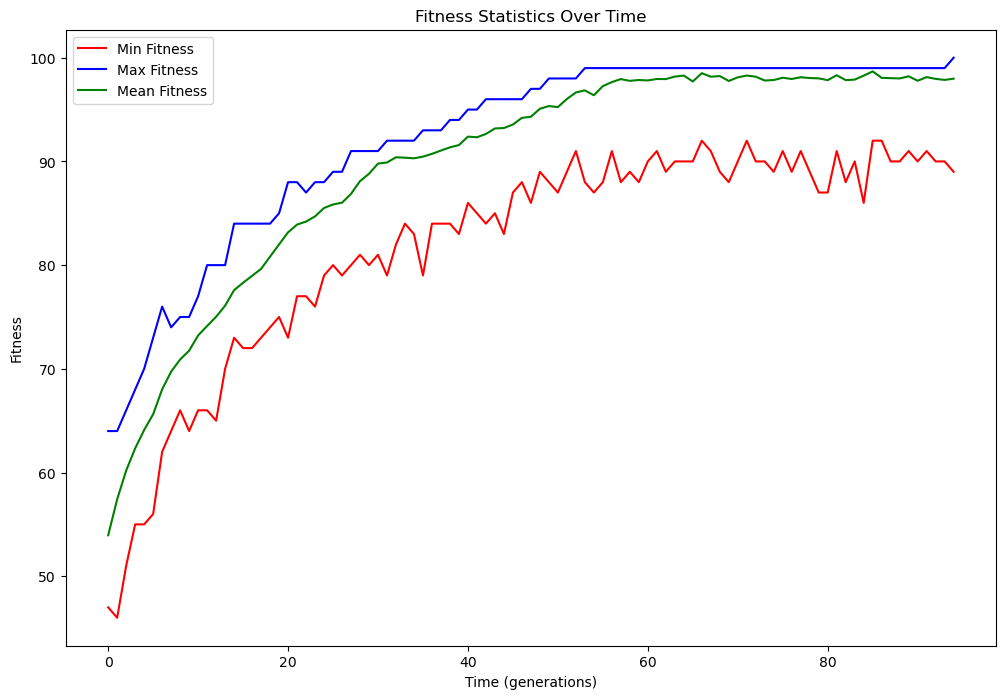

In [5]:
mins = [l['min'] for l in log]
maxs = [l['max'] for l in log]
means = [l['mean'] for l in log]

plt.figure(figsize=(12, 8))

# Plotting all statistics on one graph with different colors
plt.plot(mins, label='Min Fitness', color='red')
plt.plot(maxs, label='Max Fitness', color='blue')
plt.plot(means, label='Mean Fitness', color='green')

# Setting titles and labels
plt.title('Fitness Statistics Over Time')
plt.xlabel('Time (generations)')
plt.ylabel('Fitness')

# Adding a legend
plt.legend()

# Show the plot
plt.show()